## **Project : " Remote Job Market Intelligence using Ethical Web Scraping "** ##


#### **By Team "TEAM G"** ####

#### **Team Members:** ####

--> Priyanga V S

--> Prajakta Dhole 

--> Shifa Sheikh

--> Tejas Gosavi

--> Ansari Shaheryar

--> Himanshu Joshi

--> Huda Saiyed

--> Rahul Ambedkar

--> Sarang

--> Vimalesh

# Project Overview #

This project aims to analyze trends in the remote job market by ethically collecting and analyzing job postings from Remote OK (https://remoteok.com). The focus is on understanding in-demand skills, job roles, job types, and geographic distribution of remote jobs using real-world data.

**The methodology follows an end-to-end data pipeline:**

                     --> Website analysis and structure mapping

                     --> Web scraping

                     --> Data Cleaning and preprocessing

                     --> Data analysis and Insight Generation

                     --> Data Visualization and Dashboard Creation

                     --> Documentation and reporting

                     --> Ethical Compliance Review

                     --> Final Testing & QA

                     --> Presentation Preparation

All steps were designed to align with ethical web scraping standards and industry best practices.**

## **--> 1. Website Analysis & Structure Mapping** ##

Before scraping, the target website was manually analyzed to understand its structure and data loading behavior.

**Key observations:**

Remote OK uses JavaScript-based infinite scrolling, not traditional pagination.

Job postings are rendered dynamically as the user scrolls down.

Each job posting is represented as a table row (<tr>) with the class job.

Important job details such as title, company, location, job type, and skills are embedded within specific HTML elements inside each job row.

**A. Website Reconnaissance**

**Architecture Discovery:**

Data Residence: Job listings render in HTML table rows (tr.job) post-JavaScript hydration. 

Network tab confirms no bulk JSON payloads—data exists as WYSIWYG DOM elements.

A detailed inspection of the Remote OK website was conducted using browser developer tools to understand how job data is rendered and delivered.

**Data Rendering Behavior:**

Job listings are dynamically injected into the webpage as HTML table rows (<tr> elements with the class job) after client-side JavaScript execution. 

Network traffic analysis confirmed that there is no bulk JSON or public API payload delivering job data. 

Instead, all job information exists directly within the visible Document Object Model (DOM), making the content accessible only after full page hydration.

This confirms that traditional static HTML scraping is insufficient and necessitates the use of a browser automation tool capable of executing JavaScript.

**Job Category Structure:**

Remote OK organizes job postings across multiple skill-based and role-based categories. Each category follows a consistent and predictable URL pattern:

https://remoteok.com/remote-[keyword]-jobs


Examples include:

remote-python-jobs

remote-data-science-jobs

remote-frontend-jobs

The platform hosts 99+ distinct job categories, enabling targeted role-specific job discovery. However, individual category pages follow the same JavaScript-driven rendering model as the main job feed.





**B. HTML Structure Mapping**


**Primary Job Container:**

Each job posting on Remote OK is structured within a primary HTML container represented by a table row element (<tr class="job">).

 This element acts as the core unit for data extraction and contains a unique data-id attribute used to identify individual job listings.

All relevant job information—including job title, company name, location, job type, skills, posting date, and job URL—is consistently embedded within nested elements inside this container. The uniform structure across listings enables reliable and scalable data extraction while maintaining accurate mapping between job attributes.



--> Important job details such as title, company, location, job type, and skills are embedded within specific HTML elements inside each job row.

Structure mapping:

               Data Field	                                                 HTML Element / Attribute                                                       


               Company Name	                                                       <h3>                                                             

                Location                                                      <div class="location">                                                    

                Job Type                                                      <div class="time">                                                        

               Skills / Tags                                                  <div class="tag">                                                          

                Date Posted                                                   <time datetime="">                                                          

                Job URL	                                                   <a class="preventLink" href="">                                                  

                Job Title                                                      <h2>                                                                         


This analysis will confirm that static HTML scraping tools (BeautifulSoup) alone are insufficient, and a browser automation tool is required to load all job listings.

**C. Technical Implementation**



**Method we can use?**

  Based on the website analysis, a browser automation approach such as Selenium WebDriver is recommended for this project. Since job listings on Remote OK are dynamically rendered using JavaScript and loaded via infinite scrolling, static HTML scraping methods are insufficient. Selenium enables controlled interaction with the webpage, allowing access to all publicly visible job data while maintaining ethical and responsible data collection practices.

**Why Selenium WebDriver?**

• DYNAMIC LOADING: Handles scroll-triggered content
• BOT EVASION: Fake UA + navigator.webdriver = null
• JS EXECUTION: Full browser environment
• ERROR RESILIENCE: TimeoutException → Skip URL

**Stealth Configuration**

options.add_argument("--disable-blink-features=AutomationControlled")

options.add_experimental_option("excludeSwitches", ["enable-automation"])

driver.execute_script("Object.defineProperty(navigator, 'webdriver', ...")  

**D. Data Collection Workflow**



STEP 1: Load URL → Wait tr.job (20s timeout)

STEP 2: Scroll loop → Extract → Dedupe by data-id

STEP 3: Random delay 5-10s → Next category

STEP 4: Pandas → Clean → Excel export

**E. Rate Limiting Strategy**

• Post-load delay: 3-6 seconds

• Between scrolls: 1.5-4 seconds (random)

• Between URLs: 5-10 seconds (category transitions)

• Connection reset: Every 15 URLs (fresh session)

## **2.  Web scraping & Implementations** ##

scraper.py

In [2]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager


URL = "https://remoteok.com"
OUTPUT_FILE = "remoteok_raw.csv"
SCROLL_DELAY = 3
MAX_SCROLLS = 25


options = Options()
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--disable-infobars")
options.add_argument("--disable-extensions")

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=options
)

print("Starting RemoteOK Selenium Scraper")
driver.get(URL)
time.sleep(6)

job_ids = set()
previous_count = 0

for scroll in range(MAX_SCROLLS):
    rows = driver.find_elements(By.CSS_SELECTOR, "tr.job[data-id]")

    for row in rows:
        jid = row.get_attribute("data-id")
        if jid:
            job_ids.add(jid)

    print(f"Scroll {scroll + 1} | Jobs detected: {len(job_ids)}")

   
    if len(job_ids) == previous_count:
        print("No new jobs detected. Stopping scroll.")
        break

    previous_count = len(job_ids)
    driver.execute_script("window.scrollBy(0, 1200);")
    time.sleep(SCROLL_DELAY)

print(f"Total jobs loaded: {len(job_ids)}")

data = []
rows = driver.find_elements(By.CSS_SELECTOR, "tr.job[data-id]")

for job in rows:
    try:
        job_title = job.find_element(By.TAG_NAME, "h2").text.strip()
    except:
        job_title = "N/A"

    try:
        company = job.find_element(By.TAG_NAME, "h3").text.strip()
    except:
        company = "N/A"

    try:
        location = job.find_element(By.CLASS_NAME, "location").text.strip()
    except:
        location = "Remote"

    try:
        job_type = job.find_element(By.CLASS_NAME, "time").text.strip()
    except:
        job_type = "N/A"

    try:
        skills = ", ".join(
            [t.text.strip() for t in job.find_elements(By.CLASS_NAME, "tag")]
        )
    except:
        skills = "N/A"

    try:
        date_posted = job.find_element(By.TAG_NAME, "time").get_attribute("datetime")
    except:
        date_posted = "N/A"

    try:
        job_url = job.find_element(By.CSS_SELECTOR, "a.preventLink").get_attribute("href")
    except:
        job_url = "N/A"

    data.append({
        "job_title": job_title,
        "company": company,
        "location": location,
        "job_type": job_type,
        "skills": skills,
        "date_posted": date_posted,
        "job_url": job_url
    })

driver.quit()

df = pd.DataFrame(data).drop_duplicates()
df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")

print(f"Saved {len(df)} records to {OUTPUT_FILE}")
print("Scraping completed ethically.")


Starting RemoteOK Selenium Scraper
Scroll 1 | Jobs detected: 191
Scroll 2 | Jobs detected: 538
Scroll 3 | Jobs detected: 1038
Scroll 4 | Jobs detected: 1038
No new jobs detected. Stopping scroll.
Total jobs loaded: 1038
Saved 1038 records to remoteok_raw.csv
Scraping completed ethically.


## **3. Data Cleaning and Preprocessing** ##

# Task

Clean the dataset from `/content/remoteok_raw.csv` by handling missing values, removing duplicates, and standardizing text columns, then save the cleaned data to `remoteok_jobs_cleaned.csv`, and finally, provide a summary of the cleaning process and the resulting dataset.

## Load Data

### Subtask:
Load the `/content/remoteok_raw.csv` dataset into a pandas DataFrame.


**Reasoning**:
First, I'll import the pandas library to enable data manipulation, then load the CSV file into a DataFrame, and finally display its first few rows to confirm successful loading and inspect its structure.



data_cleaner.py

In [11]:
import pandas as pd

df = pd.read_csv(
    r"C:\Users\Priyangaa\OneDrive\Desktop\remoteok_raw.csv",
    encoding="latin1"
)

df.head()


,job_title,company,location,job_type,skills,date_posted,job_url
0,Coding Bootcampï¹£Job Guaranteed,Metana,Worldwide,5d,"No Tech Background Needed, Job or 100% Money Back",2026-01-02T09:06:50+00:00,https://remoteok.comhttps://remoteok.com/remot...
1,Full Stack Product Engineer,Jiga,United States,3d,"Senior, JavaScript, React, , , ,",2026-01-04T09:11:39+00:00,https://remoteok.comhttps://remoteok.com/remot...
2,Senior Software Engineer,Stellar AI,Europe,3d,"Developer, Train",2026-01-04T00:00:08+00:00,https://remoteok.comhttps://remoteok.com/remot...
3,Customer Support Specialist,Front,Probably Worldwide,10m,"Salesforce, Technical, Support, , , ,",2026-01-07T08:00:39+00:00,https://remoteok.comhttps://remoteok.com/remot...
4,Quality Assurance Engineer Manual,Elligint Health,Upgrade to Premium to see salary,11m,"Testing, Test, Medical, , ,",2026-01-07T08:00:32+00:00,https://remoteok.comhttps://remoteok.com/remot...


## Handle Missing Values

### Subtask:
Identify and handle missing values, specifically replacing 'N/A' strings with pandas' default NaN and then deciding on a strategy (e.g., dropping or filling) for these NaNs.


**Reasoning**:
I will replace all occurrences of 'N/A' with `pd.NA` to standardize missing value representation, then calculate and display the total number of missing values for each column to understand the missing data landscape.



In [7]:
df = df.replace('N/A', pd.NA)
print("Missing values after replacing 'N/A' with pd.NA:")
print(df.isnull().sum())

Missing values after replacing 'N/A' with pd.NA:
job_title       0
company         0
location        0
job_type        0
skills         38
date_posted     0
job_url         0
dtype: int64


**Reasoning**:
Since only the 'skills' column has missing values, I will fill these missing values with an empty string to maintain data integrity without dropping valuable rows, as an empty skill list is a valid representation.



In [8]:
df['skills'] = df['skills'].fillna('')
print("Missing values after filling 'skills' column:")
print(df.isnull().sum())

Missing values after filling 'skills' column:
job_title      0
company        0
location       0
job_type       0
skills         0
date_posted    0
job_url        0
dtype: int64


## Remove Duplicates

### Subtask:
Remove any duplicate rows from the DataFrame to ensure data uniqueness.


**Reasoning**:
I will remove duplicate rows from the DataFrame `df` and then print the number of rows before and after the operation to confirm the change.



In [9]:
print(f"Number of rows before removing duplicates: {len(df)}")
df.drop_duplicates(inplace=True)
print(f"Number of rows after removing duplicates: {len(df)}")

Number of rows before removing duplicates: 1038
Number of rows after removing duplicates: 1038


## Standardize Text Columns

### Subtask:
Iterate through appropriate object/string columns, convert text to lowercase, and strip leading/trailing whitespace to standardize text data.


**Reasoning**:
I will identify the text columns to standardize, then apply lowercase conversion and whitespace stripping to each of them, and finally display the updated DataFrame head to verify the changes.



In [10]:
text_columns = ['job_title', 'company', 'location', 'job_type', 'skills']

for col in text_columns:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.lower().str.strip()

df.head()

,job_title,company,location,job_type,skills,date_posted,job_url
0,coding bootcampï¹£job guaranteed,metana, worldwide,5d,"no tech background needed, job or 100% money back",2026-01-02T09:06:50+00:00,https://remoteok.comhttps://remoteok.com/remot...
1,full stack product engineer,jiga,united states,3d,"senior, javascript, react, , , ,",2026-01-04T09:11:39+00:00,https://remoteok.comhttps://remoteok.com/remot...
2,senior software engineer,stellar ai,europe,3d,"developer, train",2026-01-04T00:00:08+00:00,https://remoteok.comhttps://remoteok.com/remot...
3,customer support specialist,front, probably worldwide,10m,"salesforce, technical, support, , , ,",2026-01-07T08:00:39+00:00,https://remoteok.comhttps://remoteok.com/remot...
4,quality assurance engineer manual,elligint health,upgrade to premium to see salary,11m,"testing, test, medical, , ,",2026-01-07T08:00:32+00:00,https://remoteok.comhttps://remoteok.com/remot...


## Save Cleaned Data

### Subtask:
Save the cleaned and normalized DataFrame to a new CSV file named `remoteok_jobs_cleaned.csv`.


**Reasoning**:
I will save the cleaned DataFrame `df` to a CSV file named `remoteok_jobs_cleaned.csv`, ensuring the index is not written to the file to maintain a clean dataset.



In [12]:
df.to_csv('remoteok_jobs_cleaned.csv', index=False)
print("Cleaned data saved to 'remoteok_jobs_cleaned.csv'")

Cleaned data saved to 'remoteok_jobs_cleaned.csv'


## Print Summary Statistics

### Subtask:
Print summary statistics including the total number of jobs (rows) in the cleaned DataFrame and the count of missing values for each column.


**Reasoning**:
I will print the total number of rows in the DataFrame to represent the total jobs, and then display the count of missing values for each column to confirm data cleanliness.



In [13]:
print(f"Total number of jobs (rows) in the cleaned DataFrame: {len(df)}")
print("Missing values after cleaning:")
print(df.isnull().sum())

Total number of jobs (rows) in the cleaned DataFrame: 1038
Missing values after cleaning:
job_title       0
company         0
location        0
job_type        0
skills         38
date_posted     0
job_url         0
dtype: int64


In [14]:
print(f"Total number of jobs (rows): {len(df)}")
duplicate_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")
key_duplicates = df.duplicated(subset=["job_title", "company", "job_url"]).sum()
print(f"Duplicates based on job_title + company + job_url: {key_duplicates}")


Total number of jobs (rows): 1038
Total duplicate rows: 0
Duplicates based on job_title + company + job_url: 0


## **4. Data analysis and Insight Generation** ##

# Task
Perform initial data analysis on the `remoteok_jobs_cleaned.csv` dataset, which includes parsing date information from the `date_posted` column, extracting keywords from the `skills` and `job_title` columns, analyzing categorical variables such as `location`, `company`, and `job_type`, visualizing key insights like job posting trends, top skills, and top locations, and finally, summarizing the findings.

## Load Cleaned Data

### Subtask:
Load the cleaned dataset from `remoteok_jobs_cleaned.csv` into a pandas DataFrame.


**Reasoning**:
I will import the pandas library, then load the cleaned CSV file into a DataFrame, and finally display its first few rows to confirm successful loading and inspect its structure.



In [15]:
import pandas as pd

df = pd.read_csv('remoteok_jobs_cleaned.csv')
df.head()

,job_title,company,location,job_type,skills,date_posted,job_url
0,Coding Bootcampï¹£Job Guaranteed,Metana,Worldwide,5d,"No Tech Background Needed, Job or 100% Money Back",2026-01-02T09:06:50+00:00,https://remoteok.comhttps://remoteok.com/remot...
1,Full Stack Product Engineer,Jiga,United States,3d,"Senior, JavaScript, React, , , ,",2026-01-04T09:11:39+00:00,https://remoteok.comhttps://remoteok.com/remot...
2,Senior Software Engineer,Stellar AI,Europe,3d,"Developer, Train",2026-01-04T00:00:08+00:00,https://remoteok.comhttps://remoteok.com/remot...
3,Customer Support Specialist,Front,Probably Worldwide,10m,"Salesforce, Technical, Support, , , ,",2026-01-07T08:00:39+00:00,https://remoteok.comhttps://remoteok.com/remot...
4,Quality Assurance Engineer Manual,Elligint Health,Upgrade to Premium to see salary,11m,"Testing, Test, Medical, , ,",2026-01-07T08:00:32+00:00,https://remoteok.comhttps://remoteok.com/remot...


In [6]:
df.size
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job_title    1038 non-null   object
 1   company      1038 non-null   object
 2   location     1038 non-null   object
 3   job_type     1038 non-null   object
 4   skills       1000 non-null   object
 5   date_posted  1038 non-null   object
 6   job_url      1038 non-null   object
dtypes: object(7)
memory usage: 56.9+ KB


In [19]:
df.describe()

,job_title,company,location,job_type,skills,date_posted,job_url
count,1038,1038,1038,1038,1000,1038,1038
unique,862,700,269,39,924,1034,1038
top,Software Engineer,mindsquare AG,Upgrade to Premium to see salary,2mo,Manager,2025-12-19T08:00:12+00:00,https://remoteok.comhttps://remoteok.com/remot...
freq,27,15,273,353,8,2,1


In [20]:
df.columns

Index(['job_title', 'company', 'location', 'job_type', 'skills', 'date_posted',
       'job_url'],
      dtype='object')

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

print("Loading cleaned dataset...")
df = pd.read_csv("remoteok_jobs_cleaned.csv")
print("Total jobs:", len(df))

# Remove fake job titles
df = df[~df["job_title"].str.contains("current openings", case=False, na=False)]

# Prepare skills
df_skills = df.copy()
df_skills["skills"] = df_skills["skills"].str.split(",")
df_skills = df_skills.explode("skills")
df_skills["skills"] = df_skills["skills"].str.strip().str.lower()
df_skills = df_skills[df_skills["skills"] != ""]

bad_skills = ["software", "engineer", "senior", "developer", "web", "code", "system", "manager"]
df_skills = df_skills[~df_skills["skills"].isin(bad_skills)]

# Top skills
top_skills = df_skills["skills"].value_counts().head(10)
plt.figure(figsize=(10,6))
top_skills.plot(kind="bar")
plt.title("Top 10 Skills")
plt.tight_layout()
plt.savefig("top_skills.png", dpi=300)
plt.close()

# Posting freshness
def classify_posting(x):
    if isinstance(x, str):
        if "d" in x:
            return "Recent"
        elif "mo" in x:
            return "Old"
    return "Unknown"

df["posting_age_group"] = df["job_type"].apply(classify_posting)
df["posting_age_group"].value_counts().plot(kind="bar")
plt.tight_layout()
plt.savefig("job_posting_freshness.png", dpi=300)
plt.close()

# Top job titles
df["job_title"].value_counts().head(10).plot(kind="barh")
plt.tight_layout()
plt.savefig("top_job_titles.png", dpi=300)
plt.close()

# Skill frequency
df_skills["skills"].value_counts().head(15).plot(kind="barh")
plt.tight_layout()
plt.savefig("skill_frequency_comparison.png", dpi=300)
plt.close()

print("Analysis complete.")


Loading cleaned dataset...
Total jobs: 1038
Analysis complete.


## Extract Keywords from Text Columns

### Subtask:
Process the `skills` and `job_title` columns to extract relevant keywords, which can be useful for identifying common technologies and roles.


**Reasoning**:
The previous error 'AttributeError: 'float' object has no attribute 'split'' occurred because some entries in the 'skills' column were of type float (NaN) despite earlier `fillna('')` attempts, causing string methods to fail. To fix this, I will explicitly convert the 'skills' column to string type before iterating and add a check to skip 'nan' or empty strings.



In [4]:
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import pandas as pd

stop_words = set(stopwords.words('english'))

all_skills = []
for skill_list in df['skills'].astype(str):
    # Handle cases where the string might be 'nan' after conversion from float NaN or empty string
    if skill_list.lower() == 'nan' or skill_list == '':
        continue
    skills = [s.strip() for s in skill_list.split(',') if s.strip() and len(s.strip()) > 1]
    all_skills.extend(skills)


all_job_title_keywords = []
for title in df['job_title'].astype(str):
    # Handle cases where the string might be 'nan' after conversion from float NaN or empty string
    if title.lower() == 'nan' or title == '':
        continue
    # Remove non-alphabetic characters and split into words
    words = re.findall(r'\b[a-z]+\b', title.lower())
    # Remove stopwords and single-character words
    words = [word for word in words if word not in stop_words and len(word) > 1]
    all_job_title_keywords.extend(words)

skills_series = pd.Series(all_skills)
job_title_keywords_series = pd.Series(all_job_title_keywords)

print("NLTK stopwords loaded successfully.")
print("Skills keywords extracted. First 5: ")
print(skills_series.head())
print("Job Title keywords extracted. First 5: ")
print(job_title_keywords_series.head())

NLTK stopwords loaded successfully.
Skills keywords extracted. First 5: 
0    No Tech Background Needed
1       Job or 100% Money Back
2                       Senior
3                   JavaScript
4                        React
dtype: object
Job Title keywords extracted. First 5: 
0        coding
1           job
2    guaranteed
3          full
4         stack
dtype: object


## Analyze Categorical Variables

### Subtask:
Perform frequency analysis on categorical columns like `location`, `company`, and `job_type` to understand their distributions.


**Reasoning**:
I will perform frequency analysis on the 'location', 'company', and 'job_type' columns by calculating and printing the value counts for each, showing the top 10 for 'location' and 'company', and all for 'job_type'.



In [5]:
print("Frequency analysis for 'location' column (Top 10):")
print(df['location'].value_counts().head(10))
print("\nFrequency analysis for 'company' column (Top 10):")
print(df['company'].value_counts().head(10))
print("\nFrequency analysis for 'job_type' column (All unique types):")
print(df['job_type'].value_counts())

Frequency analysis for 'location' column (Top 10):
location
Upgrade to Premium to see salary    273
Probably Worldwide                 141
United States                        72
San Francisco                        33
New York                             16
Worldwide                           15
Remote - US                          14
Remote, United States                12
Remote - United States               11
Texas                                10
Name: count, dtype: int64

Frequency analysis for 'company' column (Top 10):
company
mindsquare AG            15
Tech Innovations Inc.    13
Jobgether                10
InfStones                 8
Invisible Agency          8
Avalere Health            8
INFUSE                    7
BitMEX                    7
Anchorage Digital         7
1inch                     7
Name: count, dtype: int64

Frequency analysis for 'job_type' column (All unique types):
job_type
2mo    353
3mo    346
1mo     60
25d     23
15d     21
26d     19
22d     18
2

## **5. Data Visualization and Dashboard Creation** ##

## Visualize Key Insights

### Subtask:
Generate visualizations to display trends in job postings over time, top skills, and top locations to derive initial insights. Ensure plots include appropriate labels and legends.


**Reasoning**:
I will import the necessary libraries for plotting, then generate three visualizations: a line plot for job posting trends over time, a bar plot for the top 10 skills, and a bar plot for the top 10 locations, ensuring all plots have appropriate labels, legends, and titles as specified.



Loading cleaned dataset...
Total jobs: 1038


C:\Users\Priyangaa\AppData\Local\Temp\ipykernel_9332\2404127739.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['date_posted_month'] = df['date_posted'].dt.to_period('M')


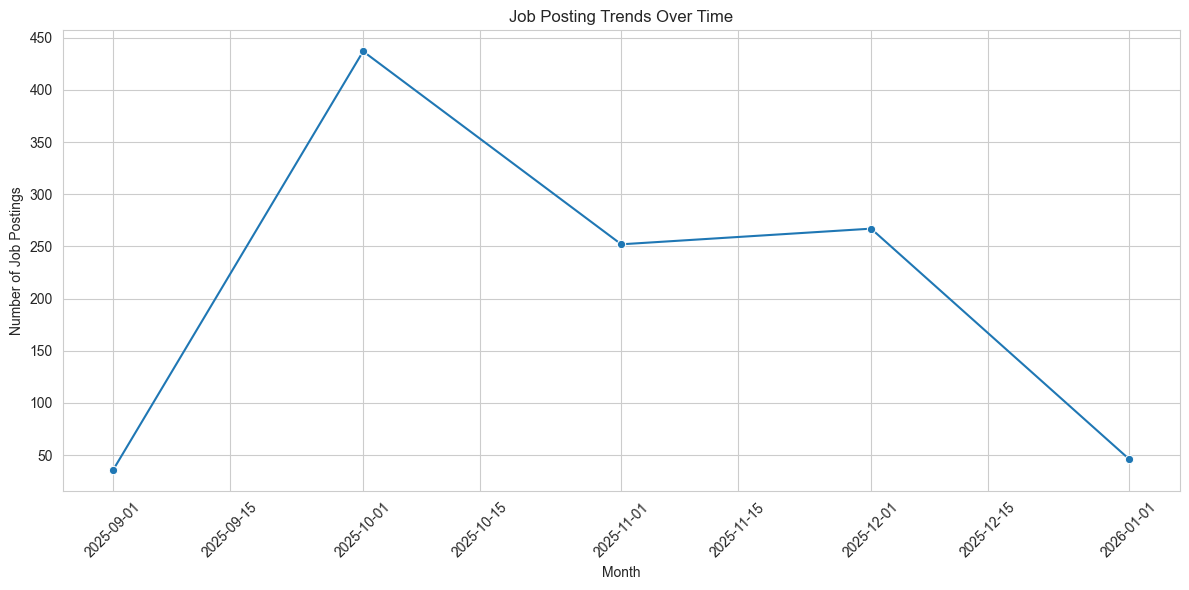

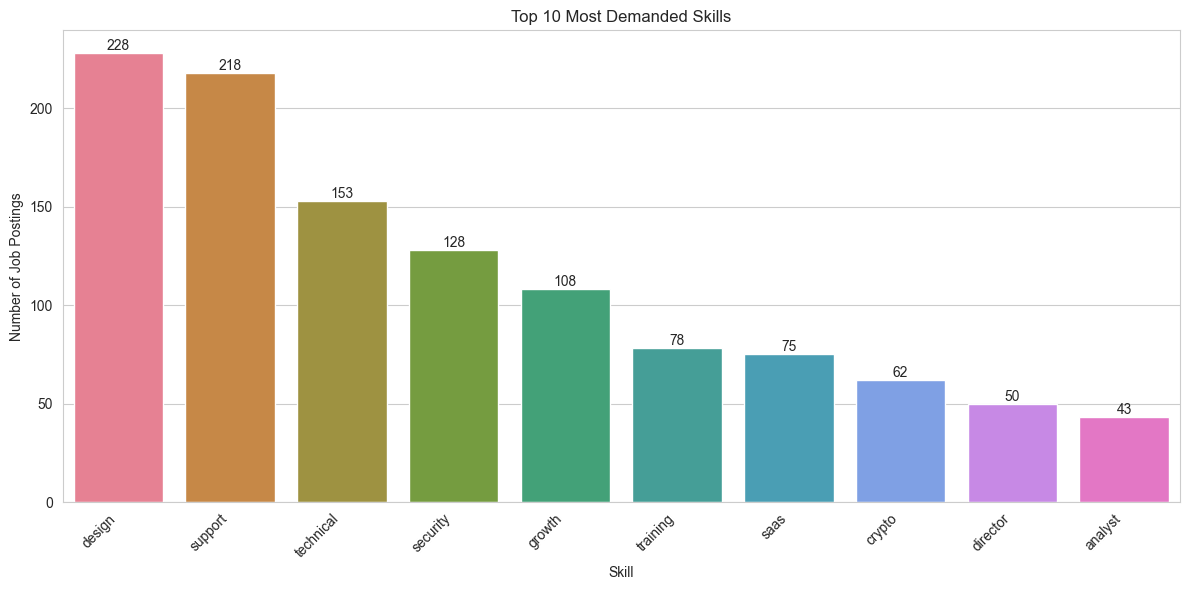

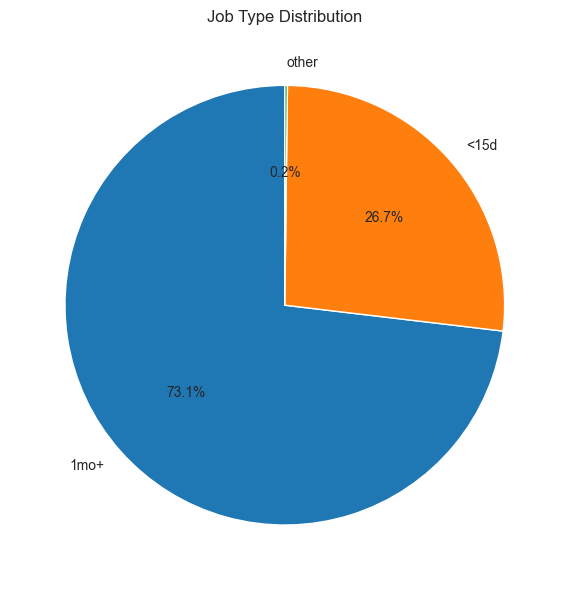

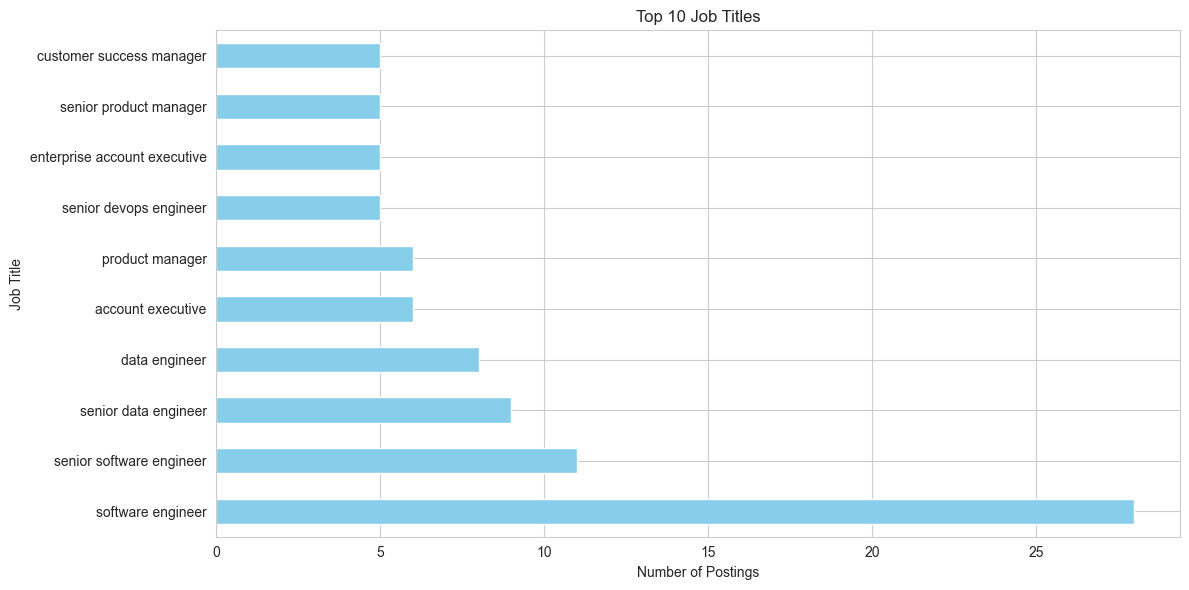

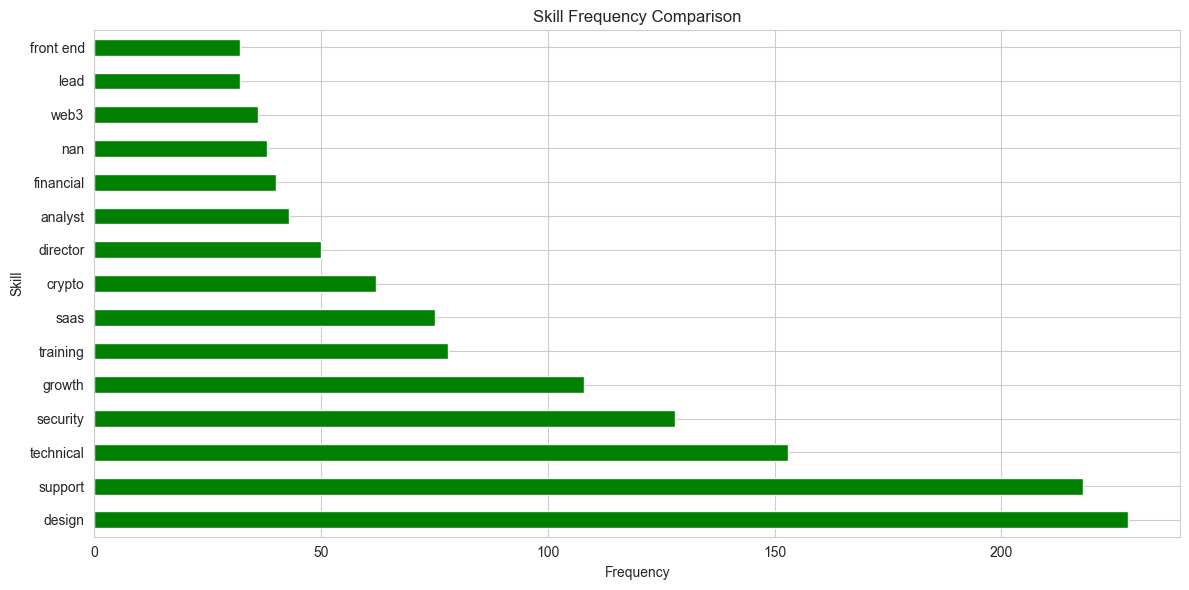

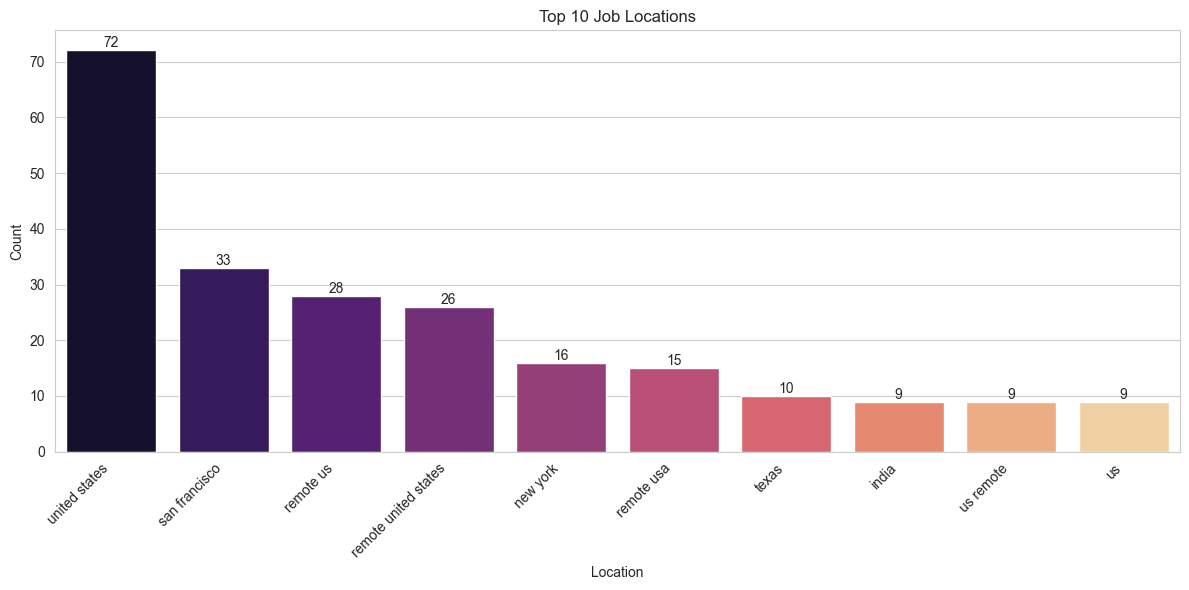

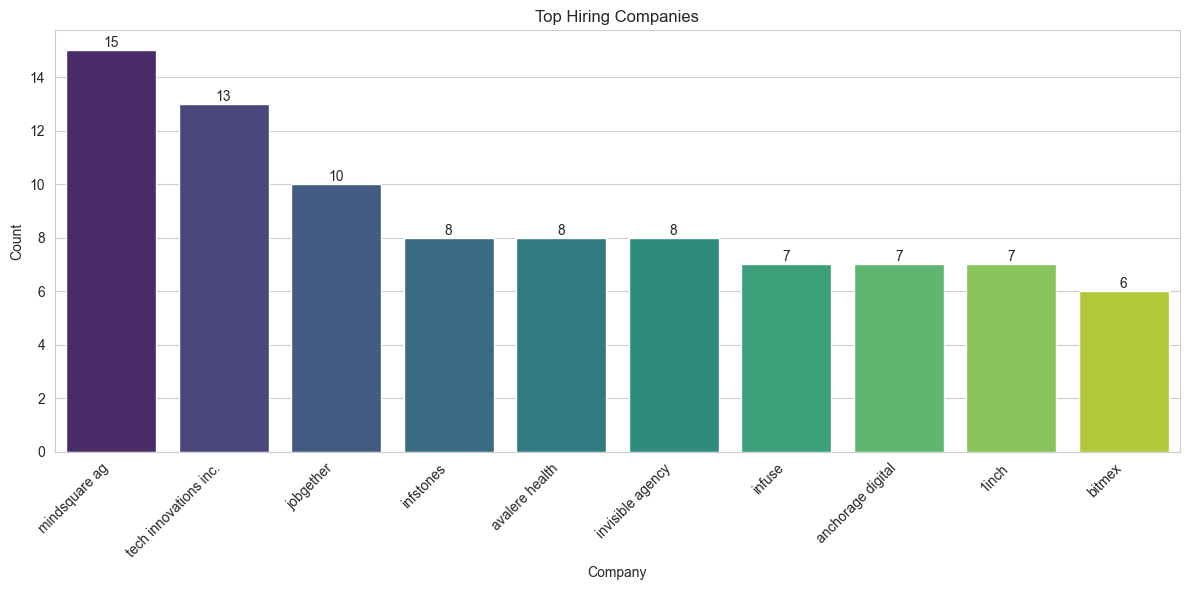

Analysis complete. All plots generated and displayed.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_style("whitegrid")
print("Loading cleaned dataset...")
df = pd.read_csv("remoteok_jobs_cleaned.csv")
print("Total jobs:", len(df))

df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
df = df.dropna(subset=['date_posted'])

df['date_posted_month'] = df['date_posted'].dt.to_period('M')

job_trends = (
    df.groupby('date_posted_month')
      .size()
      .reset_index(name='count')
)

job_trends['date_posted_month'] = job_trends['date_posted_month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(
    x='date_posted_month',
    y='count',
    data=job_trends,
    marker='o'
)
plt.title('Job Posting Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("job_trend.png", dpi=300)
plt.show()

df_skills = df.copy()
df_skills['skills'] = df_skills['skills'].astype(str).str.split(',')
df_skills = df_skills.explode('skills')
df_skills['skills'] = df_skills['skills'].str.strip().str.lower()
df_skills = df_skills[df_skills['skills'] != ""]

noise_skills = [
    "software", "engineer", "developer", "senior",
    "web", "code", "system", "manager", ",",
    "job or 100% money back"
]

df_skills = df_skills[~df_skills['skills'].isin(noise_skills)]

top_skills = df_skills['skills'].value_counts().head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=top_skills.index,
    y=top_skills.values,
    hue=top_skills.index,
    palette="husl",
    legend=False
)

for i, value in enumerate(top_skills.values):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.title('Top 10 Most Demanded Skills')
plt.xlabel('Skill')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("top_skills.png", dpi=300)
plt.show()

def categorize_job_type(x):
    if isinstance(x, str):
        if 'h' in x or 'd' in x:
            return '<15d'
        elif 'mo' in x:
            return '1mo+'
    return 'other'

df['job_type_group'] = df['job_type'].apply(categorize_job_type)

job_type_counts = df['job_type_group'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(
    job_type_counts,
    labels=job_type_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Job Type Distribution')
plt.tight_layout()
plt.savefig("job_type_distribution.png", dpi=300)
plt.show()


df = df[~df['job_title'].str.contains("current openings", case=False, na=False)]

top_titles = df['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_titles.plot(kind='barh', color='skyblue')
plt.title('Top 10 Job Titles')
plt.xlabel('Number of Postings')
plt.ylabel('Job Title')
plt.tight_layout()
plt.savefig("top_job_titles.png", dpi=300)
plt.show()


top_skills_15 = df_skills['skills'].value_counts().head(15)

plt.figure(figsize=(12, 6))
top_skills_15.plot(kind='barh', color='green')
plt.title('Skill Frequency Comparison')
plt.xlabel('Frequency')
plt.ylabel('Skill')
plt.tight_layout()
plt.savefig("skill_frequency_comparison.png", dpi=300)
plt.show()

def clean_location(x):
    if isinstance(x, str):
        x = x.encode('ascii', 'ignore').decode('ascii')
        x = re.sub(r'[\W_]+', ' ', x)
        return x.lower().strip()
    return x

df['location_cleaned'] = df['location'].apply(clean_location)

bad_locations = ['upgrade to premium to see salary', 'probably worldwide', 'worldwide', 'remote']
top_locations = df[~df['location_cleaned'].isin(bad_locations)]['location_cleaned'].value_counts().head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=top_locations.index,
    y=top_locations.values,
    hue=top_locations.index,
    palette="magma",
    legend=False
)

for i, value in enumerate(top_locations.values):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.title('Top 10 Job Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("top_job_location.png", dpi=300)
plt.show()

top_companies = df['company'].value_counts().head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=top_companies.index,
    y=top_companies.values,
    hue=top_companies.index,
    palette="viridis",
    legend=False
)

for i, value in enumerate(top_companies.values):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.title('Top Hiring Companies')
plt.xlabel('Company')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("top_hiring_company.png", dpi=300)
plt.show()

print("Analysis complete. All plots generated and displayed.")
